In [31]:
import pandas as pd

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load data

Loading the data as a regular `pandas.DataFrame`. Then we proceed by converting the `time` feature to `pandas.DateTime`, before making it the index of the dataframe. 

In [32]:
# Load data
data = pd.read_csv('weather_bcn.csv')

# Extract only prcp and time columns
data = pd.DataFrame(data[['prcp', 'time']], index=data.index, columns=['prcp', 'time'])

# Convert time column
data['time'] = pd.to_datetime(data['time'])

# Make time the index
data.set_index('time', inplace=True)
assert type(data.index) == pd.core.indexes.datetimes.DatetimeIndex

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1990-01-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   prcp    393 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


There are three null values out of 396 in the data set. We therefore use the Spline interpolation technique from sklearn

In [33]:
data['prcp'] = data['prcp'].interpolate(option='spline')

### Split into train and test

Help method for splitting the data set into train and test set, s.t. test contains data for the year 2022.

In [34]:
def train_test_split(df):
    assert type(df.index) == pd.core.indexes.datetimes.DatetimeIndex
    
    # Extract data for 2022
    test = df[(df.index.year == 2022)]
    train = df.drop(test.index)

    return train, test

### Extract `prcp`

Making two dataframes (train and test) containing only the index and the `prcp` feature.

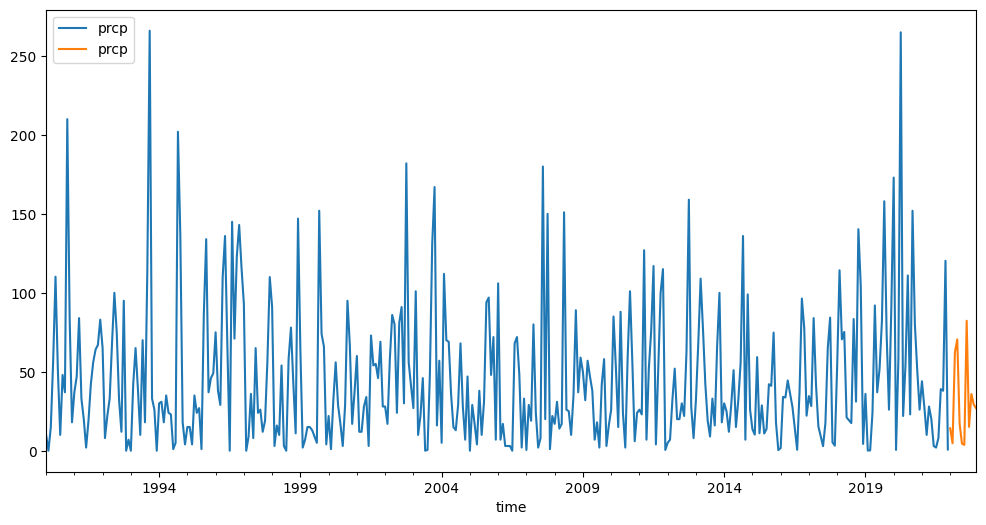

In [35]:
train, test = train_test_split(data)

plt.rcParams['figure.figsize'] = 12,6
ax = train.plot();
test.plot(ax=ax);

### Stationarity in the data

#### Seasonal decomposition
To get an initial idea of the stationarity of the data, we use `seasonal_decompose` from statsmodels to plot trend, seasonality and residuals :
- **Trend:** the trend shows variations in the mean over time. This suggests an underlying non-stationarity in the data. 
- **Seasonality:** the data is clearly seasonal. This was to be expected, as the average precipitaion (prcp) is seasonal throughout the year.
- **Residuals:** the residuals appear relatively constant around zero. This suggests that the trend and seasonality successfully captures the systematic variation in the data. 

Due to displayed trend and seasonality, the seasonal decomposition suggests that the data is non-stationary. 

#### ADF test
We also did an Augmented Dickey-Fuller test on the data. Both of the observations below suggests stationarity in the data:
- **ADF Test Statistc:** the test statistic is far more negative than the critical values at 1%, 5% and 10%. 
- **ADF p-value:** the p-value is effectively zero.

The results from the ADF test and the observations from the decomposition suggests that the data is stationary after accounting for trend and seasonality.

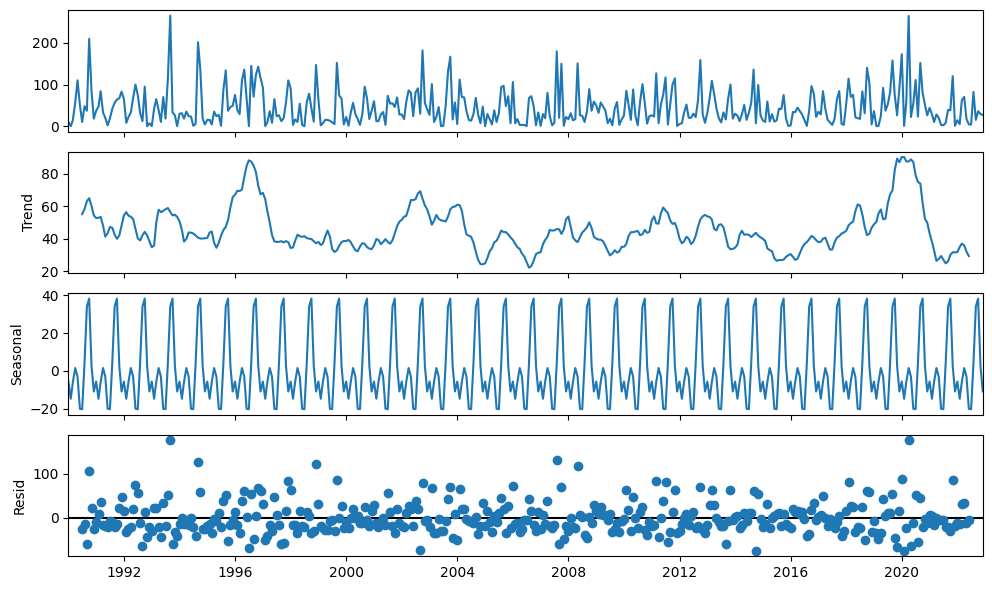

In [36]:
rcParams['figure.figsize'] = 10,6
result = seasonal_decompose(data)
result.plot();

In [37]:
adf = adfuller(train)
print('ADF test statistic:', adf[0])
print('ADF p-values:', adf[1])
print('ADF number of lags used:', adf[2])
print('ADF number of observations:', adf[3])
print('ADF critical values:', adf[4])

ADF test statistic: -16.73073895251835
ADF p-values: 1.383807586777548e-29
ADF number of lags used: 0
ADF number of observations: 383
ADF critical values: {'1%': -3.44753973676872, '5%': -2.8691160516676844, '10%': -2.57080585953957}


## ARIMA

### ARIMA Without Seasonality

We start by applying `auto_arima` without seasonality (using default parameters).

In [38]:
arima_unseasonal = auto_arima(train)
arima_unseasonal.fit(train)

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True)

The optimal parameters found by `auto_arima` has `d=0`, supporting our observation on stationarity.

In [39]:
forecast_unseasonal = arima_unseasonal.predict(n_periods= len(test))
forecast_unseasonal = pd.DataFrame(forecast_unseasonal,index = test.index,columns=['ARIMA forecast'])

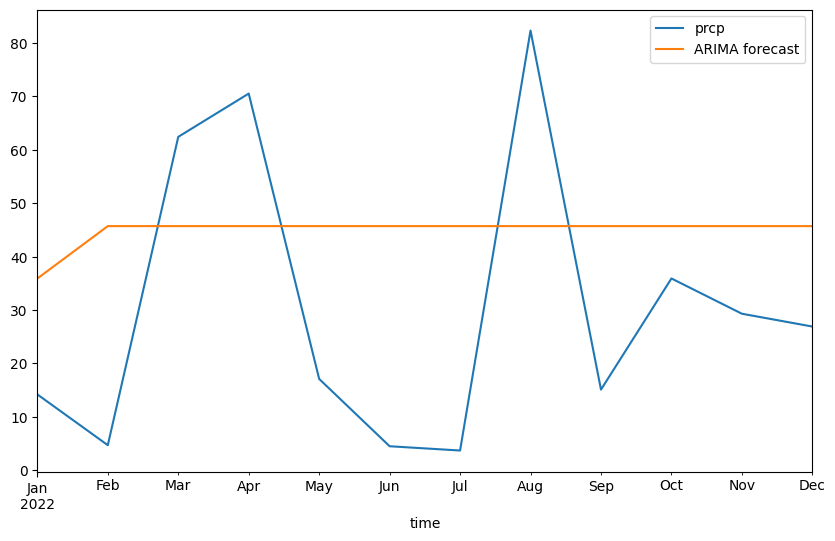

In [155]:
ax1 = test.plot()
forecast_unseasonal.plot(ax=ax1);

In [41]:
print('ARIMA auto MSE:', round(mean_squared_error(test, forecast_unseasonal),2))
print('ARIMA auto MAE:', round(mean_absolute_error(test, forecast_unseasonal),3))

ARIMA auto MSE: 859.82
ARIMA auto MAE: 27.347


### ARIMA With Seasonality

We proceed by training a new ARIMA model, this time with the annual seasonality shown by the decomposition (`m=12`).

In [42]:
arima_seasonal = auto_arima(train, error_action='ignore', seasonal=True, m=12)
arima_seasonal.fit(train)

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [43]:
forecast_seasonal = arima_seasonal.predict(n_periods=len(test))
forecast_seasonal = pd.DataFrame(forecast_seasonal,index = test.index,columns=['ARIMA forecast (seasonal)'])

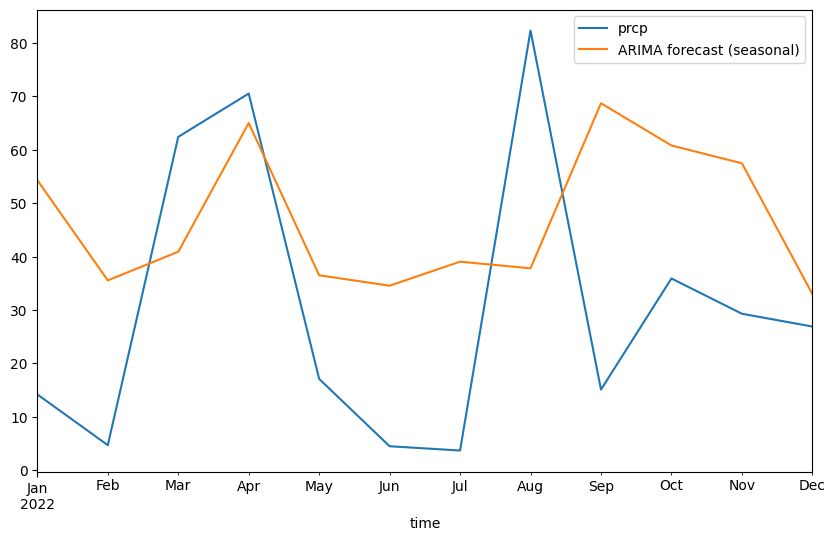

In [156]:
ax1 = test.plot()
forecast_seasonal.plot(ax=ax1);

In [45]:
print('ARIMA seasonal MSE:', round(mean_squared_error(test, forecast_seasonal),2))
print('ARIMA seasonal MAE:', round(mean_absolute_error(test, forecast_seasonal),3))

ARIMA seasonal MSE: 990.11
ARIMA seasonal MAE: 28.331


## Exponential Smoothing

In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ES_forecaster = ExponentialSmoothing(
    endog=train['prcp'],
    seasonal='add',
    seasonal_periods=12,
    trend='add'
).fit(
)


# Forecast future values
ES_forecast = ES_forecaster.forecast(12) 

ES_forecast = pd.DataFrame(ES_forecast, index = test.index,columns=['Exponential smoothing'])

/Users/magnus/development/education/ai_applied_to_engineering/assignment_2/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


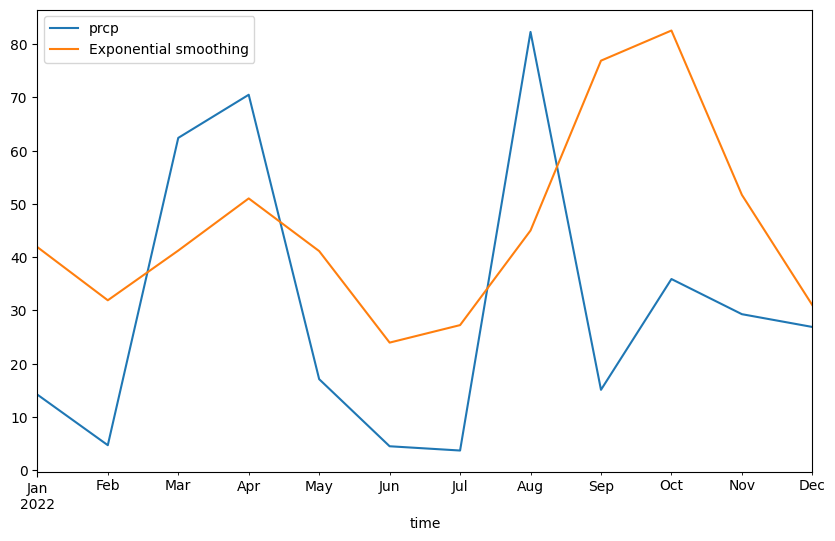

In [157]:
ax1 = test.plot()
ES_forecast.plot(ax=ax1);

In [48]:
print('Exponential Smoothing MSE:', round(mean_squared_error(test, ES_forecast),2))
print('Exponential Smoothing MAE:', round(mean_absolute_error(test, ES_forecast),3))

Exponential Smoothing MSE: 979.25
Exponential Smoothing MAE: 27.903


## Lag features

To enable the use of a regression model, we extract some features from the `tavg` column:
- **Quarter** - the quarter of the year.
- **Month** - the month of the year.
- **Last month** - the `tavg` value of last month. Lag feature.
- **Last year** - the `tavg` value of last year. Lag feature.

In [115]:
def extract_quarter(month):
    if month <= 3:
        return 1
    elif month <= 6:
        return 2
    elif month <= 9:
        return 3
    else:
        return 4
    

def lag_features(df, feature, pres=pd.DataFrame()):
    df['month'] = df.index.month

    # Add quarterly feature
    df['quarter'] = df['month'].apply(extract_quarter)

    # To lag last year's value, we need to see if the index is continuous
    continuous_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
    assert (len(continuous_range) == len(df.index) and all(continuous_range == df.index))

    # Lag values
    df['last_month'] = df[feature].shift(1)
    df['last_2_month'] = df[feature].shift(2)
    df['last_3_month'] = df[feature].shift(3)
    df['last_year'] = df[feature].shift(12)

    # If pres is provided
    if not pres.empty:
        df['pres'] = pres

    # Because of the lag from the previous year, we need to drop the first 12 entries
    df = df.iloc[12:]

    return df

In [144]:
def predict(dates, data, feature, model, pres=pd.DataFrame()):

    data = data.copy()
    # Make DataFrame for the data to predict and for the predictions
    forecast_df = pd.DataFrame(index=[dates[0]])
    predictions_df = pd.DataFrame(index=dates, columns=['prediction'])

    # Features in the prepared data
    features = data.columns.tolist()
    features.remove(feature)

    # Add month and quarter features
    forecast_df['month'] = forecast_df.index.month
    forecast_df['quarter'] = forecast_df['month'].apply(extract_quarter)

    # Add the last known data to the forecast_df 

    if not pres.empty:
        forecast_df = forecast_df.assign(
            last_month=data.iloc[-1][feature],
            last_2_month=data.iloc[-2][feature],
            last_3_month=data.iloc[-3][feature],
            last_year=data.iloc[-13][feature],
            pres=pres[0]
        )
    else:
        forecast_df = forecast_df.assign(
            last_month=data.iloc[-1][feature],
            last_2_month=data.iloc[-2][feature],
            last_3_month=data.iloc[-3][feature],
            last_year=data.iloc[-13][feature],
        )
        
    # Apply the recursive forecasting
    for i in range(12):
        # Current index
        current_index = forecast_df.index[i]

        # Predict next months pres
        input_data = forecast_df.loc[[current_index], features]

        # input_data = pd.DataFrame(index=[current_index], data=forecast_df.iloc[i], columns=features)
        prediction = model.predict(input_data)[0]

        # Add the prediction
        predictions_df.loc[predictions_df.index[i], 'prediction'] = prediction

        # Update the input features for the next forecast
        if (i < 11): # Don't perform this step for the last month
            
            current_index = forecast_df.index[i]
            next_index = predictions_df.index[i+1]

            new_row = {
                'month': next_index.month, 
                'quarter': extract_quarter(next_index.month),
                'last_month': prediction,
                'last_2_month': forecast_df.loc[current_index, 'last_month'],
                'last_3_month': forecast_df.loc[current_index, 'last_2_month'],
                'last_year': data[feature].iloc[-12 + (next_index.month - 1)]
            }

            if not pres.empty:
                new_row['pres'] = pres.iloc[i]

            forecast_df = pd.concat([forecast_df, pd.DataFrame(new_row, index=[next_index])], ignore_index=False)

    return predictions_df

In [130]:
lag_df = train.copy()
lag_df = lag_features(lag_df, 'prcp')

### Train model

We opt for the `HistGradientBoostRegressor` from scikit-learn. 

In [131]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Split data into X and y
y_train = lag_df['prcp']
X_train = lag_df.drop('prcp', axis=1, inplace=False)

# Train the model
HGBR_model = HistGradientBoostingRegressor(random_state=42)
HGBR_model.fit(X_train, y_train)

HistGradientBoostingRegressor(random_state=42)

Next we need to prepare the forecasting data. As the next feature is dependent on the previous feature, and we will predict for the coming 12 months, we apply *recursive forecasting*.

In [132]:
predict_dates = test.index
HGBR_predictions = predict(predict_dates, lag_df, 'prcp', HGBR_model)

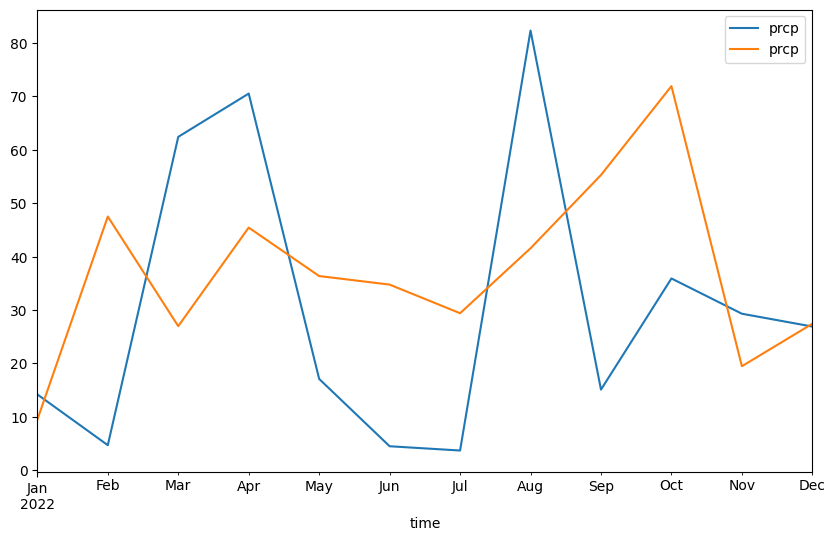

In [133]:
ax1 = test.plot()
HGBR_predictions.plot(ax=ax1);

In [134]:
print('HistGradientBoostRegressor MSE:', round(mean_squared_error(test, HGBR_predictions.values),2))
print('HistGradientBoostRegressor MAE:', round(mean_absolute_error(test, HGBR_predictions.values),3))

HistGradientBoostRegressor MSE: 862.4
HistGradientBoostRegressor MAE: 25.873


## Lag Features with pres

Extract pres data

In [151]:
# Load data
pres_data = pd.read_csv('weather_bcn.csv')

# Extract only pres and time columns
pres_data = pd.DataFrame(pres_data[['pres', 'time']], index=pres_data.index, columns=['pres', 'time'])

# Convert time column
pres_data['time'] = pd.to_datetime(pres_data['time'])

# Make time the index
pres_data.set_index('time', inplace=True)
assert type(pres_data.index) == pd.core.indexes.datetimes.DatetimeIndex

pres_data['pres'] = pres_data['pres'].interpolate(option='spline')

Add `pres` column to the `prcp` predictions.

In [152]:
# Make new lagged df for prcp containing pres
lag_df = train.copy()
lag_df = lag_features(lag_df, 'prcp', pres_data['pres'])

# Split data into X and y
y_train = lag_df['prcp']
X_train = lag_df.drop('prcp', axis=1, inplace=False)

# Train the new model
HGBR_model = HistGradientBoostingRegressor(random_state=42)
HGBR_model.fit(X_train, y_train)

# Make new predictions
predict_dates = test.index
HGBR_predictions = predict(predict_dates, lag_df, 'prcp', HGBR_model, lag_df['pres'])


/var/folders/0j/09kq_s112r5gz6_30yv10dwr0000gn/T/ipykernel_45234/4159022864.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pres=pres[0]


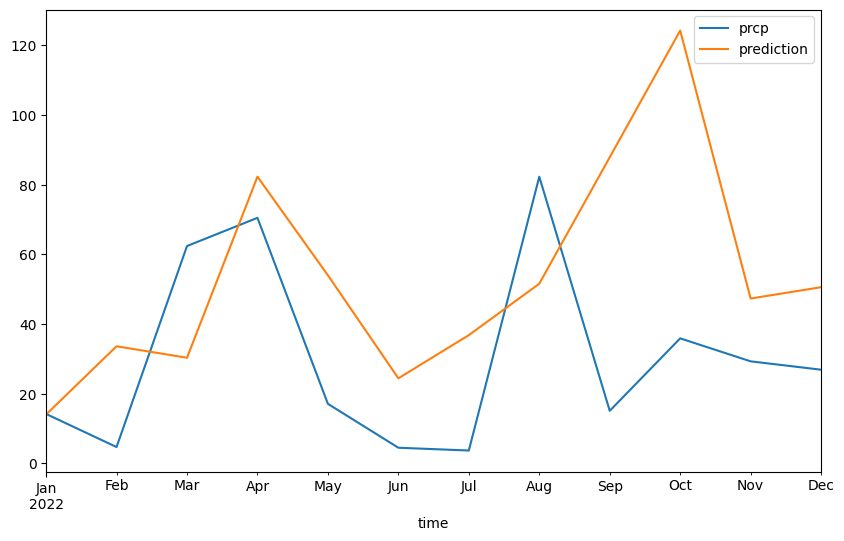

In [153]:
ax1 = test.plot()
HGBR_predictions.plot(ax=ax1);

In [154]:
print('HistGradientBoostRegressor MSE:', round(mean_squared_error(test, HGBR_predictions.values),2))
print('HistGradientBoostRegressor MAE:', round(mean_absolute_error(test, HGBR_predictions.values),3))

HistGradientBoostRegressor MSE: 1649.88
HistGradientBoostRegressor MAE: 33.043


# Comparison of methods